## Run in colab

In [1]:
!wget https://raw.githubusercontent.com/kayeschong/breaking2048/master/games.py

--2020-08-15 20:57:16--  https://raw.githubusercontent.com/kayeschong/breaking2048/master/games.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6011 (5.9K) [text/plain]
Saving to: ‘games.py’

games.py            100%[===================>]   5.87K  --.-KB/s    in 0s      

2020-08-15 20:57:16 (68.3 MB/s) - ‘games.py’ saved [6011/6011]



In [5]:
from games import Env2048

import os
import time
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from IPython.display import clear_output

In [2]:
class DQCNN(nn.Module):

    def __init__(self, height, width, n_actions):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)

        self.fc = nn.Linear(64 * (height-1) * (width-1), out_features=128)
        self.out = nn.Linear(128, n_actions)


    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        x = self.fc(x.view(x.size(0), -1))
        x = self.out(x) # flatten
        return x

Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward', 'done')
)

class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
    
    def append(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [3]:
# TODO: Agent interface to interact with GUI
class DQNAgent():
    def __init__(self, model_path="dqcnn.pt", device=None, train=False):
        
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        self.model_path=model_path

        self.model = DQCNN(4, 4, 4).to(self.device)
        if os.path.exists(self.model_path):        
            self.model.load_state_dict(torch.load(self.model_path))
            self.model.eval()
        else:
            if train:
                self.train()
            else:
                print("Please train model first or specify weights path")
    
    def train(self):
        # Hyperparams
        BATCH_SIZE = 4096
        MEMORY_SIZE = 100000
        GAMMA = 0.99
        EPS = 0.2
        TARGET_UPDATE = 20
        MA_WINDOW = 100
        LEARNING_RATE = 0.1

        device = self.device

        env = Env2048()

        rewards_window = deque(maxlen=MA_WINDOW)
        memory = ReplayMemory(MEMORY_SIZE)
        loss_fn = nn.MSELoss() # f(inp, target)
        policy_net = DQCNN(env.height, env.width, env.action_space.n).to(device)
        target_net = DQCNN(env.height, env.width, env.action_space.n).to(device)
        target_net.load_state_dict(policy_net.state_dict())
        target_net.eval()
        optimizer = optim.Adam(params=policy_net.parameters(), lr=LEARNING_RATE)
        
        NUM_EPISODES = 500
        possible_values = [0] + [2**i for i in range(1, 13)]

        for episode in range(NUM_EPISODES):
            print("episode:", episode)
            env.reset()
            done = False
            obs = env.grid.copy()
            # Convert tiles to range 0-11
            obs[obs==0] = 1
            obs = np.log2(obs)
            # # Convert tiles to binary
            # obs = np.stack([env.grid == val for val in possible_values]).astype(int)
            
            curr_state = torch.Tensor(obs).unsqueeze(0).to(device)
            
            rng = np.random.default_rng(seed=None)
            episode_reward = torch.tensor([0])
            while not done:
                with torch.no_grad():
                    if EPS > rng.random():
                        out = torch.rand((1, env.action_space.n)) # explore
                    else:
                        out = policy_net(curr_state) # exploit
                    # # Filter to valid actions
                    out[:, env.get_invalid_moves()] = 0

                    action = out.argmax(dim=1).to(device)
                    obs, reward, done, info = env.step(action.item())
                    # Convert tiles to range 0-11
                    obs[obs==0] = 1
                    obs = np.log2(obs)
                    # # Convert tiles to binary
                    # obs = np.stack([obs == val for val in possible_values]).astype(int)
                    next_state = torch.Tensor(obs).unsqueeze(0).to(device)
                    episode_reward += reward
                    reward = torch.tensor(reward).unsqueeze(0).to(device)
                    memory.append(Experience(curr_state, action, next_state, reward, torch.tensor(done).unsqueeze(0).to(device)))
                    curr_state = next_state
                
                # Start training once min samples reach
                if len(memory) >= BATCH_SIZE:
                    experience_batch = memory.sample(BATCH_SIZE)
                    batch_states, batch_actions, batch_next_states, batch_rewards, batch_done = self.unpack_batch(experience_batch)
                    
                    current_Q = policy_net(batch_states).gather(dim=1, index=batch_actions.unsqueeze(-1))
                    next_Q, max_indexes = target_net(batch_next_states).max(dim=1)
                    # If lose game, we know all future action-values are 0
                    next_Q[batch_done] = 0
                    # Expected current Q based on bellman eq
                    target_Q = batch_rewards + (next_Q * GAMMA)
                    
                    loss = loss_fn(current_Q, target_Q.unsqueeze(1))
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            if episode % TARGET_UPDATE == 0:
                target_net.load_state_dict(policy_net.state_dict())

        torch.save(policy_net.state_dict(), self.model_path)
        self.model.load_state_dict(torch.load(self.model_path))
        self.model.eval()

    def unpack_batch(self, experiences):
        # Convert batch of Experiences to Experience of batches
        batch = Experience(*zip(*experiences))

        batch_states = torch.cat(batch.state)
        batch_actions = torch.cat(batch.action)
        batch_next_states = torch.cat(batch.next_state)
        batch_rewards = torch.cat(batch.reward)
        batch_done = torch.cat(batch.done)

        return batch_states, batch_actions, batch_next_states, batch_rewards, batch_done
    
    def get_move(self, grid) -> int:
        obs = grid.copy()
        obs[obs==0] = 1
        obs = np.log2(obs)
        # obs = np.stack([env.grid == val for val in possible_values]).astype(int)
        curr_state = torch.Tensor(obs).unsqueeze(0).to(self.device)
        with torch.no_grad():
            # DQN pred action-value
            out = policy_net(curr_state)
            # Filter valid actions, set to low q-value, take best valid move
            out[:, env.get_invalid_moves()] = -1e6
            # DQN best action-value from valid actions    
            action = out.argmax(dim=1).item()
        
        return action
# Add to class as helper
action_map = {
    0: 'LEFT',
    1: 'UP',
    2: 'RIGHT',
    3: 'DOWN',
}

In [6]:
temp = DQNAgent(train=True)

episode: 0
episode: 1
episode: 2
episode: 3
episode: 4
episode: 5
episode: 6
episode: 7
episode: 8
episode: 9
episode: 10
episode: 11
episode: 12
episode: 13
episode: 14
episode: 15
episode: 16
episode: 17
episode: 18
episode: 19
episode: 20
episode: 21
episode: 22
episode: 23
episode: 24
episode: 25
episode: 26
episode: 27
episode: 28
episode: 29
episode: 30
episode: 31
episode: 32
episode: 33
episode: 34
episode: 35
episode: 36
episode: 37
episode: 38
episode: 39
episode: 40
episode: 41
episode: 42
episode: 43
episode: 44
episode: 45
episode: 46
episode: 47
episode: 48
episode: 49
episode: 50
episode: 51
episode: 52
episode: 53
episode: 54
episode: 55
episode: 56
episode: 57
episode: 58
episode: 59
episode: 60
episode: 61
episode: 62
episode: 63
episode: 64
episode: 65
episode: 66
episode: 67
episode: 68
episode: 69
episode: 70
episode: 71
episode: 72
episode: 73
episode: 74
episode: 75
episode: 76
episode: 77
episode: 78
episode: 79
episode: 80
episode: 81
episode: 82
episode: 83
ep

## Experimenting

In [5]:
def unpack_batch(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    batch_states = torch.cat(batch.state)
    batch_actions = torch.cat(batch.action)
    batch_next_states = torch.cat(batch.next_state)
    batch_rewards = torch.cat(batch.reward)
    batch_done = torch.cat(batch.done)

    return batch_states, batch_actions, batch_next_states, batch_rewards, batch_done

In [6]:
# Hyperparams
BATCH_SIZE = 4096
MEMORY_SIZE = 100000
GAMMA = 0.99
EPS = 0.2
TARGET_UPDATE = 20
MA_WINDOW = 100
LEARNING_RATE = 0.1

# TODO: Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = Env2048()

rewards_window = deque(maxlen=MA_WINDOW)
memory = ReplayMemory(MEMORY_SIZE)
loss_fn = nn.MSELoss() # f(inp, target)
policy_net = DQCNN(env.height, env.width, env.action_space.n).to(device)
target_net = DQCNN(env.height, env.width, env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=LEARNING_RATE)

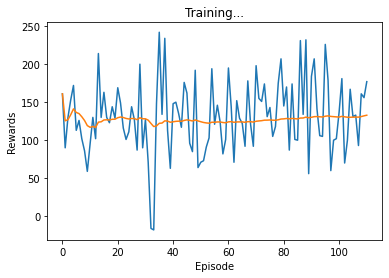

Episode 110 reward 177
100 episode reward moving avg: 132.8699951171875
Max tile 256
Memory size 15244
[[  2   4   8   2]
 [  4   8  32   4]
 [ 16   2 256   8]
 [  2  32   8   4]]


KeyboardInterrupt: ignored

In [7]:
NUM_EPISODES = 500
episode_rewards = torch.zeros(NUM_EPISODES)
moving_avg_rewards = torch.zeros(NUM_EPISODES)
max_tiles = torch.zeros(NUM_EPISODES)
possible_values = [0] + [2**i for i in range(1, 13)]
for episode in range(NUM_EPISODES):
    env.reset()
    done = False
    obs = env.grid.copy()
    obs[obs==0] = 1
    obs = np.log2(obs)
    # obs = np.stack([env.grid == val for val in possible_values]).astype(int)
    
    curr_state = torch.Tensor(obs).unsqueeze(0).to(device)
    
    rng = np.random.default_rng(seed=None)
    episode_reward = torch.tensor([0])
    while (not done):

#         # Random
#         out = torch.rand((1, env.action_space.n))
# #         out[:, env.get_invalid_moves()] = 0
#         action = out.argmax(dim=1)
#         next_state, reward, done, info = env.step(action.item())
#         next_state = torch.Tensor(next_state).unsqueeze(0)
#         episode_reward += reward
#         reward = torch.tensor(reward).unsqueeze(0)
#         memory.append(Experience(curr_state, action, next_state, reward, torch.tensor(done).unsqueeze(0)))
#         curr_state = next_state
        
        
        # DQN
        # Select action and get next state
        with torch.no_grad():
            if EPS > rng.random():
                out = torch.rand((1, env.action_space.n)) # explore
            else:
                out = policy_net(curr_state) # exploit
            # # Filter to valid actions
            out[:, env.get_invalid_moves()] = 0

            action = out.argmax(dim=1).to(device)
            obs, reward, done, info = env.step(action.item())
            obs[obs==0] = 1
            obs = np.log2(obs)
            # obs = np.stack([obs == val for val in possible_values]).astype(int)
            next_state = torch.Tensor(obs).unsqueeze(0).to(device)
            episode_reward += reward
            reward = torch.tensor(reward).unsqueeze(0).to(device)
            memory.append(Experience(curr_state, action, next_state, reward, torch.tensor(done).unsqueeze(0).to(device)))
            curr_state = next_state
        
        # Start training once min samples reach
        if len(memory) >= BATCH_SIZE:
            experience_batch = memory.sample(BATCH_SIZE)
            batch_states, batch_actions, batch_next_states, batch_rewards, batch_done = unpack_batch(experience_batch)
            
            current_Q = policy_net(batch_states).gather(dim=1, index=batch_actions.unsqueeze(-1))
            next_Q, max_indexes = target_net(batch_next_states).max(dim=1)
            # If lose game, we know all future action-values are 0
            next_Q[batch_done] = 0
            # # if invalid move, all future action-values are 0
            # next_Q[batch_rewards == 0] = 0
            # Expected current Q based on bellman eq
            target_Q = batch_rewards + (next_Q * GAMMA)
            
            loss = loss_fn(current_Q, target_Q.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    
    # Track progress
    max_tile = np.max(env.grid)
    max_tiles[episode] = max_tile
    episode_rewards[episode] = episode_reward
    rewards_window.append(episode_reward)
    moving_avg_rewards[episode] = np.mean(rewards_window)
    # Plot rewards
    clear_output(wait=True)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.plot(episode_rewards[:episode + 1])
    plt.plot(moving_avg_rewards[:episode + 1])
    plt.pause(0.0001)
    print("Episode", episode, "reward", episode_reward.item())
    print(len(rewards_window), "episode reward moving avg:", moving_avg_rewards[episode].item())
    print("Max tile", max_tile)
    print("Memory size", len(memory))
    env.render()
    
    # Update target network every certain episodes
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

## Execute sample agent

In [ ]:
env = Env2048()
env.reset()
env.render()
done = False
obs = env.grid.copy()
obs[obs==0] = 1
obs = np.log2(obs)
# obs = np.stack([env.grid == val for val in possible_values]).astype(int)
curr_state = torch.Tensor(obs).unsqueeze(0).to(device)
rng = np.random.default_rng(seed=None)
moves = 0
while not done:
    moves += 1
    with torch.no_grad():
        out = policy_net(curr_state) # exploit
        # Filter valid actions, set to low q-value, take best valid move
        out[:, env.get_invalid_moves()] = -1e6
    
        action = out.argmax(dim=1).item()
    obs, reward, done, info = env.step(action)
    obs[obs==0] = 1
    obs = np.log2(obs)
    # obs = np.stack([obs == val for val in possible_values]).astype(int)
    curr_state = torch.Tensor(obs).unsqueeze(0).to(device)
    
    clear_output(wait=True)
    print(action_map[action])
    env.render()
    # time.sleep(0.2)

print("Max tile:", np.max(env.grid))
moves

UP
[[ 2  8  4  2]
 [ 4 16  8  4]
 [64 32 16  8]
 [16  8  4  2]]
Max tile: 64


91